In [272]:
# 라이브러리 불러오기

import threading
from dobot_api import DobotApiDashboard, DobotApi, DobotApiMove, MyType
from time import sleep
import numpy as np

# -*- coding: utf-8 -*-
from threading import Thread
import time
from tkinter import *
from tkinter import ttk, messagebox
from tkinter.scrolledtext import ScrolledText
from dobot_api import *
import json
from files.alarm_controller import alarm_controller_list
from files.alarm_servo import alarm_servo_list

In [273]:
# 라이브러리 불러오기
import threading
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# from utils import ARUCO_DICT, aruco_display
import cv2
import sys
import os

from time import sleep
from dobot_api import DobotApiDashboard, DobotApi, DobotApiMove, MyType
from ultralytics import YOLO
model = YOLO('best.pt')

In [274]:
# 통신 연결 함수

def connect_robot(ip):
    try:
        dashboard_p = 29999
        move_p = 30003
        feed_p = 30004
        print("연결 설정 중...")

        dashboard = DobotApiDashboard(ip, dashboard_p)
        move = DobotApiMove(ip, move_p)
        feed = DobotApi(ip, feed_p)
        print("연결 성공!!")

        return dashboard, move, feed

    except Exception as e:
        print("연결 실패")
        raise e

In [275]:
# 로봇 경고 초기화

def robot_clear(dashboard : DobotApiDashboard):
    dashboard.ClearError()

In [276]:
# 로봇 작동 속도 설정

def robot_speed(dashboard : DobotApiDashboard, speed_value):
    dashboard.SpeedFactor(speed_value)

In [277]:
# 그리퍼 작동 함수
# index = 1 고정
# status = { 0: OFF, 1: ON }

def gripper_DO(dashboard : DobotApiDashboard, index, status):
    dashboard.ToolDO(index, status)

In [278]:
# 로봇의 현재 자세를 출력하는 함수

def get_Pose(dashboard : DobotApiDashboard):
    dashboard.GetPose()

In [279]:
# 로봇에 좌표를 입력하여 이동하는 함수

def run_point(move: DobotApiMove, point_list: list):
    move.MovL(point_list[0], point_list[1], point_list[2], point_list[3])

In [280]:
# 피드백 제어 함수

current_actual = None   # 전역 변수 (현재 좌표)

def get_feed(feed: DobotApi):
    global current_actual
    hasRead = 0

    while True:
        data = bytes()
        while hasRead < 1440:
            temp = feed.socket_dobot.recv(1440 - hasRead)
            if len(temp) > 0:
                hasRead += len(temp)
                data += temp
        hasRead = 0
        a = np.frombuffer(data, dtype=MyType)

        if hex((a['test_value'][0])) == '0x123456789abcdef':
            current_actual = a["tool_vector_actual"][0]     # Refresh Properties
        sleep(0.001)

In [281]:
ARUCO_DICT = {
	"DICT_4X4_50": cv2.aruco.DICT_4X4_50,
	"DICT_4X4_100": cv2.aruco.DICT_4X4_100,
	"DICT_4X4_250": cv2.aruco.DICT_4X4_250,
	"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
	"DICT_5X5_50": cv2.aruco.DICT_5X5_50,
	"DICT_5X5_100": cv2.aruco.DICT_5X5_100,
	"DICT_5X5_250": cv2.aruco.DICT_5X5_250,
	"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
	"DICT_6X6_50": cv2.aruco.DICT_6X6_50,
	"DICT_6X6_100": cv2.aruco.DICT_6X6_100,
	"DICT_6X6_250": cv2.aruco.DICT_6X6_250,
	"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
	"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
	"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
	"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
	"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
	"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
	"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
	"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
	"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
	"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
}

def aruco_display(corners, ids, rejected, image):
	if len(corners) > 0:
		# flatten the ArUco IDs list
		ids = ids.flatten()
		# loop over the detected ArUCo corners
		for (markerCorner, markerID) in zip(corners, ids):
			# extract the marker corners (which are always returned in
			# top-left, top-right, bottom-right, and bottom-left order)
			corners = markerCorner.reshape((4, 2))
			(topLeft, topRight, bottomRight, bottomLeft) = corners
			# convert each of the (x, y)-coordinate pairs to integers
			topRight = (int(topRight[0]), int(topRight[1]))
			bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
			bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
			topLeft = (int(topLeft[0]), int(topLeft[1]))

			cv2.line(image, topLeft, topRight, (0, 255, 0), 2)
			cv2.line(image, topRight, bottomRight, (0, 255, 0), 2)
			cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), 2)
			cv2.line(image, bottomLeft, topLeft, (0, 255, 0), 2)
			# compute and draw the center (x, y)-coordinates of the ArUco
			# marker
			cX = int((topLeft[0] + bottomRight[0]) / 2.0)
			cY = int((topLeft[1] + bottomRight[1]) / 2.0)
			cv2.circle(image, (cX, cY), 4, (0, 0, 255), -1)
			# draw the ArUco marker ID on the image
			cv2.putText(image, str(markerID),(topLeft[0], topLeft[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
				0.5, (0, 255, 0), 2)
			print("[Inference] ArUco marker ID: {}".format(markerID))
			# show the output image
	return image

In [282]:
def detect_marker(image, marker_type):
	# ArUCo 마커 이미지 읽기

	# 이미지 전처리
	h,w,_ = image.shape
	width=600
	height = int(width*(h/w))
	image = cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)

	# verify that the supplied ArUCo tag exists and is supported by OpenCV
	if ARUCO_DICT.get(marker_type, None) is None:
		print(f"ArUCo tag type '{marker_type}' is not supported")
		sys.exit(0)

	# load the ArUCo dictionary, grab the ArUCo parameters, and detect
	# the markers
	print("Detecting '{}' tags....".format(marker_type))
	arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT[marker_type])
	arucoParams = cv2.aruco.DetectorParameters_create()
	corners, ids, rejected = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

	# print(f"corners : {corners}")
	# print(f"ids : {ids}")

	# ArUCo 마커 검출 결과에 대한 시각화
	detected_markers = aruco_display(corners, ids, rejected, image)

	return detected_markers

In [283]:
def pose_esitmation(frame, aruco_dict_type, matrix_coefficients, distortion_coefficients):
    rvec = []
    tvec = []
    points = []
    corners = None

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.aruco_dict = cv2.aruco.Dictionary_get(aruco_dict_type)
    parameters = cv2.aruco.DetectorParameters_create()
    try :
        corners, ids, rejected_img_points = cv2.aruco.detectMarkers(gray, cv2.aruco_dict, parameters=parameters)
        ids = [i[0] for i in ids]
        print(f"ids : {ids}")
        if len(corners) > 0:
            for i in range(0, len(ids)):
                # Estimate pose of each marker and return the values rvec and tvec---(different from those of camera coefficients)
                tmp_rvec, tmp_tvec, tmp_markerPoints = cv2.aruco.estimatePoseSingleMarkers(corners[i], 0.02, matrix_coefficients,
                                                                        distortion_coefficients)
                rvec.append(tmp_rvec)
                tvec.append(tmp_tvec)
                points.append(tmp_markerPoints)
    
    except :
        pass
    
    return rvec, tvec, corners, ids

def run_aruco(image, marker_type = "DICT_4X4_100"):

    if ARUCO_DICT.get(marker_type, None) is None:
        print(f"ArUCo tag type is not supported")
        sys.exit(0)

    aruco_dict_type = ARUCO_DICT[marker_type]
    calibration_matrix_path = "./pose_ArUCo/calibration_matrix.npy"
    distortion_coefficients_path = "./pose_ArUCo/distortion_coefficients.npy"
    
    k = np.load(calibration_matrix_path)
    d = np.load(distortion_coefficients_path)


    rvec, tvec, corners, ids = pose_esitmation(image, aruco_dict_type, k, d)
    return rvec, tvec, corners, ids

In [284]:
def transform_cam_to_robot(cam_pose_list, ids, yaw_angle_by_robot):
	# 로봇 베이스 좌표계
	# distance_cam_between_robot = [0.35, 0.02, 0.33]
	distance_cam_between_robot = [0.30, 0.00, 0.44]
	pose_final_dict = {1:None, 2:None, 3:None, 4:None, 5:None, 6:None}

	# 두봇 좌표 보정 (unit : m -> mm)
	dobot_scale = 1000
	gripper_height = [0, 0, 0.055] 	# unit : m

	# y축 회전 행렬 (180도)
	y_angle = np.pi
	rotate_y_matrix = [[np.cos(y_angle), 0, np.sin(y_angle)], 
						[0, 1, 0],
						[-np.sin(y_angle), 0, np.cos(y_angle)]]

	# z축 회전 행렬 (-90도)
	z_angle = -np.pi/2
	rotate_z_matrix = [[np.cos(z_angle), -np.sin(z_angle), 0],
						[np.sin(z_angle), np.cos(z_angle), 0],
						[0, 0, 1]]
	rotate_y_matrix_np = np.array(rotate_y_matrix)
	rotate_z_matrix_np = np.array(rotate_z_matrix)
 
	# for i in range(len(yolo_list)) :
	# 	if yolo_list[i] != None :
	# 		yolo_np = np.array(yolo_list[i])
	# 		yolo_rotate_y = rotate_y_matrix_np.dot(yolo_np)
	# 		yolo_rotate_y = yolo_rotate_y.round(3)
	# 		yolo_rotate_y_z = rotate_z_matrix_np.dot(yolo_rotate_y)
	# 		yolo_rotate_y_z = yolo_rotate_y_z.round(3)
	# 		# print(f"cam rotate y->z : {pose_rotate_y_z}")
	# 		# 최종 좌표
	# 		yolo_final = (yolo_rotate_y_z)
	# 		pose_final_dict[i+4] = yolo_final.tolist() + [yaw_angle_by_robot, 0, 0]

 
	for i in range(len(ids)) :
		cam_pose = cam_pose_list[i*3:i*3+3]
		# list -> numpy array
		pose_np = np.array(cam_pose)
		rotate_y_matrix_np = np.array(rotate_y_matrix)
		rotate_z_matrix_np = np.array(rotate_z_matrix)

		# 내적 : y축 180도 회전 -> z축 -90도 회전
		pose_rotate_y = rotate_y_matrix_np.dot(pose_np)
		pose_rotate_y = pose_rotate_y.round(3)
		# print(f"cam rotate y : {pose_rotate_y}")

		pose_rotate_y_z = rotate_z_matrix_np.dot(pose_rotate_y)
		pose_rotate_y_z = pose_rotate_y_z.round(3)
		# print(f"cam rotate y->z : {pose_rotate_y_z}")

		# 최종 좌표
		pose_final = (pose_rotate_y_z + distance_cam_between_robot + gripper_height) * dobot_scale
		pose_final_dict[tuple(ids)[i]] = pose_final.tolist() + [yaw_angle_by_robot, 0, 0]

	return pose_final_dict

In [285]:
def ham_aruco(edit_x = -35.4, edit_y = -25.9, edit_z = -130.4, edit_yaw = 0, marker_type = "DICT_4X4_100"):
    # 웹캠 이미지 받아오기
    point_grip = None
    cap = cv2.VideoCapture(-1)
    if not cap.isOpened() :
        cap = cv2.VideoCapture(0)
    
    ret, img = cap.read()
    w, h, c = img.shape
    result = model(img)[0]
    # green, red, yellow
    colordict = result.names
    boxes = result.boxes
    
    # 웹캠 이미지를 RGB로 변환
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    yolo_list = [None, None, None]
    if len(boxes) > 0:
        for box in boxes:
            print(box)
            coords = box.boxes[0]
            print("좌표", coords)
            img_rgb = cv2.rectangle(img_rgb, (int(coords[0]), int(coords[1])), (int(coords[2]), int(coords[3])), (0, 255, 0), 2)
            img_rgb = cv2.putText(img_rgb, colordict[int(coords[-1])], (int(coords[0]), int(coords[1])-3), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0) , 2)
            
            yolo_point = [float((coords[0]+coords[2])/2), float((coords[1]+coords[3])/2), 220.]
            
            if int(coords[-1]) == 0:
                yolo_list[1] = yolo_point
            elif int(coords[-1]) == 1:
                yolo_list[0] = yolo_point
            elif int(coords[-1]) == 2:
                yolo_list[2] = yolo_point
    else:
        print("YOLO not detected")

    # 웹캠 이미지 보기
#     plt.imshow(img_rgb)
#     plt.show()

    cap.release()
    
    # 마커 검출
    detected_markers = detect_marker(image=img_rgb, marker_type=marker_type)

    # 마커 검출 이미지 보기
    plt.imshow(detected_markers)
    plt.show()
    
    # 아르코 마커로 카메라 좌표계 기준 6D pose 예측하기
    # rvec : 회전 행렬 (roll, pitch, yaw)   // unit : rads
    # tvec : 이동 행렬 (x, y, z)            // unit : meter
    # corners : 아르코 마커의 각 코너 좌표  // (x, y) 픽셀 위치
    try :
        rvec, tvec, corners, ids = run_aruco(img)

        # 간단한 전처리
        rvec = np.array(rvec).flatten() 
        tvec = np.array(tvec).flatten()
        corners = np.array(corners[0][0])

        # 회전 행렬, 이동 행렬, 마커 코너 좌표 출력
        print(f"rotate vector : {rvec} rads")
        print(f"translation vector : {tvec} meters \n")
        print(f"marker corners : {corners}")
        
        # 오차 보정을 통한 좌표 및 각도 보정
        tvec[0] = round(tvec[0], 4)
        tvec[1] = round(tvec[1], 4)
        tvec[2] = round(tvec[2], 4)
        yaw_angle_by_cam = round(rvec[-1], 4)
        print('rvec : ', rvec)

        print(f"x based camera cordinate: {tvec[0]} meter")
        print(f"y based camera cordinate: {tvec[1]} meter")
        print(f"z based camera cordinate: {tvec[2]} meter")
        print(f"yaw_angle_by_cam : {yaw_angle_by_cam} rads")
        
    # yaw 변환 각도 값 추가
        yaw_angle_by_robot = round((math.degrees(-yaw_angle_by_cam) + edit_yaw), 4)
        
    #     # 카메라 좌표계 -> 로봇 베이스 좌표계로 변환
        point_grip = transform_cam_to_robot(tvec, ids, yaw_angle_by_robot)
        
    except :
        point_grip = {1:None, 2:None, 3:None, 4:None, 5:None, 6:None}
    # yolo 결과 넣기
    for i in range(3):
        if yolo_list[i] != None :
            point_grip[i+4] = yolo_list[i]
    
#     print(f"before : {point_grip}")
#     point_grip[0] = round(point_grip[0] + edit_x, 4)
#     point_grip[1] = round(point_grip[1] + edit_y, 4)
#     point_grip[2] = round(point_grip[2] + edit_z, 4)


    print(f"xyz+yaw pose by robot, yolo : {point_grip} mm+degree")
    
    print(f"after : {point_grip}")
    ids.sort()
    
    return ids, point_grip

In [329]:
tower_pos = [246.679553, 186.088604, -22., 58.191772, 0.000000, 0.000000]

In [332]:

def get_matrix(move: DobotApiMove) :
    global tower_pos
    safe_point = [199.495090, 186.088604, -22, 58.191772, 0.000000, 0.000000]
    run_point(move, safe_point)
    sleep(1)
    input_vectors = np.array([[245., -62., 220.],
                     [298., 1., 220.],
                     [248., 64., 220.]])
    
    input_yolo = np.array([[63.4642, 145.7889, 220.],
                  [307.98185, 350.2978, 220.],
                  [543.93365, 158.0238, 220.]])
    
    target_vectors = np.array([[246.679553, -116.089551, -69.246513],
                      [335.196185, -5.053952, -69.246513],
                      [250.519658, 101.919739, -69.246513]])
    try :
        ids, result = ham_aruco()
        if len(ids) > 0:
            for id in ids:
                input_vectors[id-1] = result[id][:3]
        for i in range(3) :
            if result[i+4] != None :
                tower_pos = result[i+4]
                break
    except :
        print("aruco not detected!") 
    transformation_matrix =  target_vectors.T @ np.linalg.inv(input_vectors.T)
    yolo_matrix = target_vectors.T @ np.linalg.inv(input_yolo.T)
    
    print(transformation_matrix, yolo_matrix)
    return transformation_matrix, yolo_matrix

def set_tower_pose(pos):
    global tower_pos
    tower_pos = pos
    
set_tower_pose([199.495090, 186.088604, -22, 58.191772, 0.000000, 0.000000])
tower_pos
    

[199.49509, 186.088604, -22, 58.191772, 0.0, 0.0]

In [287]:
# 유저 파라미터
ip = "192.168.1.6"              # Robot의 IP 주소
gripper_port = 1                # 그리퍼 포트 번호
speed_value = 10                # 로봇 속도 (1~100 사이의 값 입력)

# 로봇이 이동하고자 하는 좌표 예시 (x, y, z, yaw) unit : mm, degree
point_home = [245, 5, 50, 115]
point_grip = [304, 19, -20, 16]
point_parse = [255, -54, -5, 115]

In [288]:
# 로봇 연결
dashboard, move, feed = connect_robot(ip)
dashboard.EnableRobot()
print("이제 로봇을 사용할 수 있습니다!")

# 쓰레드 설정
feed_thread = threading.Thread(target=get_feed, args=(feed,))
feed_thread.setDaemon(True)
feed_thread.start()

연결 설정 중...
연결 성공!!
Send to 192.168.1.6:29999: EnableRobot()
Receive from 192.168.1.6:29999: 0,{},EnableRobot();
이제 로봇을 사용할 수 있습니다!


/tmp/ipykernel_20599/2390342575.py:8: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  feed_thread.setDaemon(True)


Send to 192.168.1.6:30003: MovL(199.495090,186.088604,-22.000000,58.191772)
Receive from 192.168.1.6:30003: 



0: 480x640 1 green, 1 red, 1 yellow, 11.5ms
Speed: 5.7ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[ 23.7606,  81.6729, 125.0552, 194.5117,   0.9495,   1.0000]], device='cuda:0')
cls: tensor([1.], device='cuda:0')
conf: tensor([0.9495], device='cuda:0')
data: tensor([[ 23.7606,  81.6729, 125.0552, 194.5117,   0.9495,   1.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: tensor([480, 640], device='cuda:0')
shape: torch.Size([1, 6])
xywh: tensor([[ 74.4079, 138.0923, 101.2946, 112.8387]], device='cuda:0')
xywhn: tensor([[0.1163, 0.2877, 0.1583, 0.2351]], device='cuda:0')
xyxy: tensor([[ 23.7606,  81.6729, 125.0552, 194.5117]], device='cuda:0')
xyxyn: tensor([[0.0371, 0.1702, 0.1954, 0.4052]], device='cuda:0')
좌표 tensor([ 23.7606,  81.6729, 125.0552, 194.5117,   0.9495,   1.0000], device='cuda:0')
ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[256.9958, 289.3022, 355.5734, 389.8245,   0.9121,   0.0000]], device='cuda:0')
cls: tensor([0.], device='cuda:0')
conf: tens

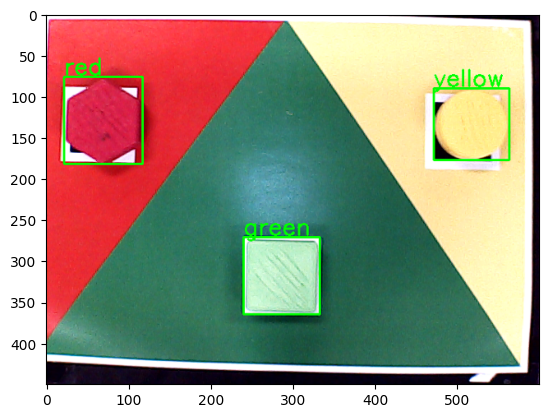

IndexError: tuple index out of range

In [289]:
cam_mat, yolo_mat = get_matrix(move)
print(cam_mat, yolo_mat)

In [ ]:
def move_yolo(move:DobotApiMove, target_color, result, step):
    try :
        if target_color == 'red':
            pos = list(yolo_mat.dot(np.array(result[4][:3])))
        elif target_color == 'green':
            pos = list(yolo_mat.dot(np.array(result[5][:3])))
        elif target_color == 'yellow':
            pos = list(yolo_mat.dot(np.array(result[6][:3])))
    except :
        pos = tower_pose    
    pos[2] = -72+17*step
    pos.append(220.0)
    run_point(move, pos)

In [ ]:
def move_aruco(move:DobotApiMove, target_color, result, step):
    if target_color == 'red':
        pos = list(cam_mat@np.array(result[1][:3]).T)
    elif target_color == 'green':
        pos = list(cam_mat@np.array(result[2][:3]).T)
    elif target_color == 'yellow':
        pos = list(cam_mat@np.array(result[3][:3]).T)
        
    pos[2] = -72+17*step
    pos.append(220.0)
    run_point(move, pos)

In [ ]:
def which_yolo(result):
    ids = []
    for i in range(1,4) :
        if result[i+3] != None:
            ids.append(i)
    return ids


0: 480x640 1 green, 1 red, 1 yellow, 5.4ms
Speed: 9.4ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[  7.4464,  93.6518, 111.9245, 208.5272,   0.9417,   1.0000]], device='cuda:0')
cls: tensor([1.], device='cuda:0')
conf: tensor([0.9417], device='cuda:0')
data: tensor([[  7.4464,  93.6518, 111.9245, 208.5272,   0.9417,   1.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: tensor([480, 640], device='cuda:0')
shape: torch.Size([1, 6])
xywh: tensor([[ 59.6854, 151.0895, 104.4781, 114.8753]], device='cuda:0')
xywhn: tensor([[0.0933, 0.3148, 0.1632, 0.2393]], device='cuda:0')
xyxy: tensor([[  7.4464,  93.6518, 111.9245, 208.5272]], device='cuda:0')
xyxyn: tensor([[0.0116, 0.1951, 0.1749, 0.4344]], device='cuda:0')
좌표 tensor([  7.4464,  93.6518, 111.9245, 208.5272,   0.9417,   1.0000], device='cuda:0')
ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[497.6781, 111.9055, 590.6053, 204.7710,   0.9220,   2.0000]], device='cuda:0')
cls: tensor([2.], device='cuda:0')
conf: tens

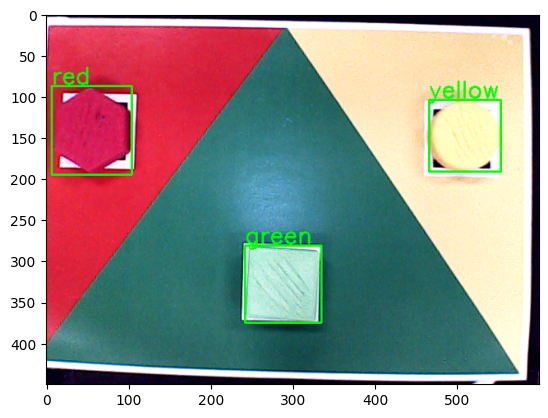

IndexError: tuple index out of range

In [293]:
ids, result = ham_aruco()

move_yolo(move, 'red', result, 1)
gripper_DO(dashboard, gripper_port, 1)
sleep(1)
move_aruco(move, 'red', result, 1)
run_point(move, point_parse)
gripper_DO(dashboard, gripper_port, 0)

In [292]:
step0 = -72
step1 = -55
step2 = -39
step3 = -22

In [ ]:
red = [246.679553,-116.089551,-72.729370,-49.407715,0.000000,0.000000]
green = [335.196185,-5.053952,-72.729370,-36.665512,0.000000,0.000000]
yellow = [250.519658,101.919739,-72.729370,-13.770685,0.000000,0.000000]

run_point(move, red)

Send to 192.168.1.6:30003: MovL(246.679553,-116.089551,-72.729370,-49.407715)
Receive from 192.168.1.6:30003: 0,{},MovL(246.679553,-116.089551,-72.729370,-49.407715);


In [ ]:
# 로봇 끄기
dashboard.DisableRobot()
dashboard.ClearError()


Send to 192.168.1.6:29999: DisableRobot()


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
# 로봇 연결
dashboard, move, feed = connect_robot(ip)
dashboard.EnableRobot()
print("이제 로봇을 사용할 수 있습니다!")

# 쓰레드 설정
feed_thread = threading.Thread(target=get_feed, args=(feed,))
feed_thread.setDaemon(True)
feed_thread.start()

연결 설정 중...
연결 성공!!
Send to 192.168.1.6:29999: EnableRobot()
Receive from 192.168.1.6:29999: 
이제 로봇을 사용할 수 있습니다!


/tmp/ipykernel_20599/2390342575.py:8: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  feed_thread.setDaemon(True)


In [ ]:
run_point(move, [149.706005,292.043178,67.113411,75.757545,0.000000,0.000000])
# 그리퍼 구동
dashboard.GetPose()
gripper_DO(dashboard, gripper_port, 1)
sleep(5)

Send to 192.168.1.6:30003: MovL(149.706005,292.043178,67.113411,75.757545)
Receive from 192.168.1.6:30003: 0,{},MovL(149.706005,292.043178,67.113411,75.757545);
